# Aula 02 - Planejamento de Sistemas Elétricos
##### OBJETIVO DA AULA 2 É SOLUCIONAR O DILEMA DO OPERADOR
##### AULAS 02D
A Programação Dinâmica Estocástica(PDE) "Didática" ou PDE "Adaptada"

Nessa aula, será a aplicação de 2 usinas, porque nos exemplos anteriores os dados eram para apenas uma usina, e adaptação do código para uma impressão do gráfico tridimensional da Função de Custo Futuro.

- LISTA E DICIONÁRIO
- APLICANDO GT E DADOS GERAIS E DICIONÁRIO COM TODOS OS DADOS DO SISTEMAS

In [2]:
lista_uhe = []
usina = {
 "Nome": "UHE MARCATO",
 "Vmax": 100.,
 "Vmin": 20.,
 "Prod": 0.95,
 "Engol": 60.,
 "AFL": [
    [ 23., 16.],
    [ 19., 14.],
    [ 15., 11.]
 ]
     #Cenários = colunas e estágios=linhas
}
lista_uhe.append(usina)

lista_uhe = []
usina = {
 "Nome": "UHE MARCATO nº2",
 "Vmax": 200.,
 "Vmin": 40.,
 "Prod": 0.85,
 "Engol": 100.,
 "AFL": [
    [ 46., 32.],
    [ 36., 28.],
    [ 30., 22.]
 ]
lista_uhe.append(usina)

#Lista de UTE - Usinas térmicas
lista_ute = []
#Primeira Usina Térmica
usina = {
    "Nome": "GT1",
    "Capacidade": 15.,
    "Custo": 10.
 }
lista_ute.append(usina)
#Segunda usina
usina = {
    "Nome": "GT2",
    "Capacidade": 10.,
    "Custo": 25.
}
lista_ute.append(usina)

#Dados Gerais - variavéis
d_gerais = {
    "CDef": 500.,
    "Carga": [100.,100.,50.,],#mes1, mês2, mês3, ..
    "N_Disc":3,
    "N_Est": 3,
    "N_Cen": 2.
}

#Sistema - Dicionário compactando todas as informações
sistema = {
    "DGer": d_gerais,
    "UHE": lista_uhe,
    "UTE": lista_ute
}
print(sistema["UTE"],[0],["Nome"])

[{'Nome': 'GT1', 'Capacidade': 15.0, 'Custo': 10.0}, {'Nome': 'GT2', 'Capacidade': 10.0, 'Custo': 25.0}] [0] ['Nome']


PROBLEMA DE DESPACHO TÉRMICO DA  AULA 01

Tabela com os seguintes dados:

   - Discretizações(Armazenamento(hm³))
   - Afluência 
   - Decisões Ótimas(Variavéis):
       1. UHEs (Volume final, Volume turbinado e Volume vertido),
       2. UTEs (Usar usina térmica 1 ou 2, GT1 e GT2)
       3. Def (Défict)
   - Custo imediato
   - Custo Ótimo
   - Custo de Operação

    FUNÇÃO OBJETIVO
    Custo Imediato

$Min \hspace{0.5cm}C_1 \cdot GT_1 + C_2 \cdot GT_2 + Cdef \cdot DEF + 0.01 \cdot V_v$

    BALANÇO HÍDRICO
    
$V_f= V_i + AFL - V_t - V_v$

    ATENDIMENTO À DEMANDA
 
$CARGA = \rho \cdot V_t + GT_1 + GT_2 + DEF$

    RESTRIÇÕES DE CANALIZAÇÃO
    Limites superiores e inferiores das variavéis de decisão

$20 \le V_f \le 100 $

$0 \le V_t \le 60 $

$0 \le V_v \le \infty $

$0 \le GT_1 \le 15 $

$0 \le GT_2 \le 25 $

$0 \le DEF \le \infty $

# Continuação Aula 02b

    CRIAÇÃO DE FUNÇÃO PARA O DESPACHO 
    DISCRETIZAÇÕES
    RESTRIÇÕES
    RESULTADOS
    GRÁFICOS
    

#### DESPACHO

    FUNÇÃO DESPACHO COMEÇA AQUI

In [6]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op
def despacho(sistema, VI, AFL, pote_de_corte, estag, imprime):

    Num_UHE = len(sistema["UHE"])
    Num_UTE = len(sistema["UTE"])
    print(Num_UTE)

    #Variavéis de Decisão de volume final
    #Por isso a necessidade de Num_UTE e Num_UHE
    vf = variable(Num_UHE, "Volume final da Usina")
    vturb = variable(Num_UHE, "Volume Turbinado da Usina")
    vv = variable(Num_UHE, "Volume Vertido da Usina")
    gt = variable(Num_UTE, "Geração na Usina Térmica")
    deficit = variable(1, "Déficit de Energia no Sistema")
    alpha = variable(1, "Custo Futuro")

    print(vf.name)
    print(deficit.value)
    #Após resolver o problema de otimização "none"

    #CONSTRUÇÃO DA FUNÇÃO OBJETIVO
    #𝑀𝑖𝑛𝐶1⋅𝐺𝑇1+𝐶2⋅𝐺𝑇2+𝐶𝑑𝑒𝑓⋅𝐷𝐸𝐹+0.01⋅𝑉𝑣
    #𝑀𝑖𝑛𝐶1⋅𝐺𝑇1+𝐶2⋅𝐺𝑇2
    fob = 0
    for i, usin in enumerate(sistema["UTE"]):
        fob += usin['Custo']*gt[i]

    #𝐶𝑑𝑒𝑓⋅𝐷𝐸𝐹
    fob += sistema["DGer"]["CDef"]*deficit[0]

    #0.01⋅𝑉𝑣
    #E percorrer todas as usinas
    for i,usin in enumerate(sistema["UHE"]):
        fob += 0.01*vv[i]
    
    fob += 1.0*alpha[0]
    print(fob)#Custo Total


    #DEFINIÇÃO DAS RESTRIÇÕES
    #BALANÇO HÍDRICO
    #𝑉𝑓=𝑉𝑖+𝐴𝐹𝐿−𝑉𝑡−𝑉𝑣
    restricoes = []
    for i, usin in enumerate(sistema["UHE"]):
        restricoes.append(vf[i] == float(VI[i]) + float(AFL[i]) - vturb[i] - vv[i])

    #ATENDIMENTO À DEMANDA
    #𝐶𝐴𝑅𝐺𝐴=𝜌⋅𝑉𝑡+𝐺𝑇1+𝐺𝑇2+𝐷𝐸𝐹
    #𝜌⋅𝑉𝑡
    AD = 0
    for i, usin in enumerate(sistema["UHE"]):
        AD += usin ["Prod"]*vturb[i]

    #𝐺𝑇1+𝐺𝑇2
    for i, usin in enumerate(sistema["UTE"]):
        AD += gt[i]

    #𝐷𝐸𝐹 - ATENDIMENTO À DEMANDA
    #Erro na equação de AD [2], porque em Py começamos a indexação em 0
    #Substituindo por estag-2
    AD += deficit[0]

    restricoes.append(AD == sistema["DGer"]["Carga"][estag-2]) #2=estágios
    print(restricoes[0])


    #RESTRIÇÕES DE CANALIZAÇÃO
    #Limites superiores e inferiores das variavéis de decisão
        #20≤𝑉𝑓≤100
        #0≤𝑉𝑡≤60
        #0≤𝑉𝑣≤∞

    for i, usin in enumerate(sistema["UHE"]):
        restricoes.append(vf[i] >= usin["Vmin"])
        restricoes.append(vf[i] <= usin["Vmax"])
        restricoes.append(vturb[i] >= usin["Engol"])
        restricoes.append(vturb[i] <= usin["Engol"])
        restricoes.append(vv[i] >= 0)

        #0≤𝐺𝑇1≤15
        #0≤𝐺𝑇2≤25
    for i, usin in enumerate(sistema["UTE"]):
        restricoes.append(gt[i] >= 0)
        restricoes.append(gt[i] <= usin["Capacidade"])

        #0≤𝐷𝐸𝐹≤∞
    restricoes.append( deficit[0] >= 0)
    
    #Restrições para alpha
    restricoes.append( alpha[0] >= 0)
    j#Nesse loop, percorrer-se por todos os cortes
    #"if" - se eu tiver um corte associado a um estágio que eu desejo
    #a variavél "eq" adiciona os termos coeficientes(CMA) e vf para cada usina
    #Por fim, somar o termo independente
    for cut in pote_de_corte:
        if cut["Estagio"] == estag:
            
            #Equação provisória (obs.: usin)
            eq = 0.
            for usin in range(Num_UHE):
                eq += float(cut["Coeficiente"][usin])*vf[usin]
            eq += float(cut["Termo_indep"])
            restricoes.append(alpha[0] >= eq)
        print(cut)
        
    
    problema = op(fob,restricoes)
    problema.solve('dense', 'glpk')
    DGer = {
        "Deficit": deficit[0].value,
        "CMO": restricoes[Num_UHE].multiplier.value[0],
        "CustoTotal": fob.value()[0],
        "CustoFuturo": alpha[0].value[0]
    }
    #Armazenar os dados das usinas hídricas
    lista_uhe = []
    for i, usin in enumerate(sistema["UHE"]):
        resultado = {
            "vf": vf[i].value()[0],
            "vturb": vturb[i].value()[0],
            "vv": vv[i].value()[0],
            "CMA": restricoes[i].multiplier.value[0]
        }
        
        lista_uhe.append(resultado)
    
    #Armazenar os dados das usinas térmicas
    lista_ute = []
    for i, usin in enumerate(sistema["UTE"]):
        resultado = {
            "gt": gt[i].value()[0],
        }
        lista_ute.append(resultado)
        
    #Dicionário de dados com todos os resultados dos problemas de otimização
    resultado = {
        "DGer": DGer,
        "UHE": lista_uhe,
        "UTE": lista_ute
    }
    
    
    if imprime:
        print("Custo Total: ",fob.value())
        
        for i, usin in enumerate(sistema['UHE']):
            print(vf.name, i,'é ', vf[i].value(),'hm³')
            print(vturb.name, i,'é ', vturb[i].value(),'hm³')
            print(vv.name, i,'é ', vv[i].value(),'hm³')
        
        for i, usin in enumerate(sistema['UTE']):
            print(gt.name, i,"é ",gt[i].value(), 'MWmed')
        
        print(deficit.name,'é', deficit[0].value(), 'MWmed')
        print(alpha.name,'é', alpha[0].value(), '$ (dólar)')

        
        for i, usin in enumerate(sistema['UHE']):
            print('Custo Marginal da Água(CMA)',i,' é: ', restricoes[i].multiplier.value)
            print('O Valor Marginal de Operação é: ', restricoes[Num_UHE].multiplier.value)
            #Mulpicador de Lagrange
            
    #Final da Função
    return(resultado)
            

- DISCRETIZAÇÕES

3 (0.0,)


TypeError: list indices must be integers or slices, not numpy.float64

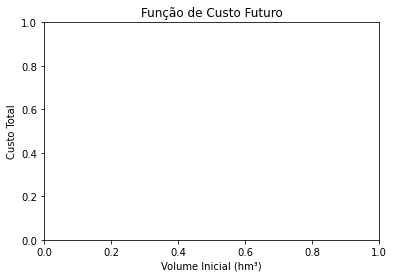

In [8]:
import itertools
from itertools import product,tee
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm #Mapa de cores
import time


Num_UHE = len(sistema["UHE"])
Num_UTE = len(sistema["UTE"])

passo = 100/ (sistema["DGer"]["N_Disc"]-1) 
#Número de discretizações, disponível em d_gerais
#Passo corresponde ao intervalo(50 em 50) ou 25 em 25 como no caso abaixo

lista = np.arange(0, 100+passo, passo)
discretizacoes = product(np.arange(0, 100+passo, passo), repeat = Num_UHE) 
#repeat corresponde as usinas
#ele passa de ser um produto e passa ser uma lista
discretizacoes = list(discretizacoes)

pote_de_corte = []

t = time.time() #Armazena o horário em que passou por essa parte do programa 
for estag in np.arange(sistema["DGer"]["N_Est"],0, -1):
    #Imprimir o gráfico da Função de Custo Futuro
    
    #Para uma usina
    if Num_UHE == 1:
        plt.figure(estag)
        plt.title("Função de Custo Futuro")
        plt.xlabel("Volume Inicial (hm³)")
        plt.ylabel("Custo Total")
        eixox = []
        eixoy = []
        
    #Gráfico Tridimensional
    #Para 2 usinas
    if Num_UHE == 2:
        #Atribuindo uma figura à variavél
        fig = plt.figure(estag)
        #eixos
        #Comando para declarar as projeções(dimensões)
        #Gerando um gráfico de superfície
        ax = fig.gca(projection="3d")
        #Comando para atribuir nomes do título, gráfico, etc
        ax.set_title("Função de Custo Futuro - Estágio"+str(estag))
        ax.set_xlabel("Volume Inicial UHE 1")
        ax.set_xlabel("Volume Inicial UHE 2")
        ax.set_zlabel("FCF ($)")
        #Para definir as discretizações (lista)
        Usin1 = np.arange(0, 100+passo, passo)
        Usin2 = np.arange(0, 100+passo, passo)
        #Comando da biblioteca Numpy
        Usin1, Usin2 = np.meshgrid(Usin1, Usin2)#Parâmetros de entrada
        #As saídas seram 2 array coordenados, fundamentais para compor a superfície para verificar basta print(Usin1 e rint(Usin2)
        #Matriz Custos
        Custos = np.zeros((sistema["DGer"]["N_Disc"], sistema["DGer"]["N_Disc"])
        for discret in discretizacoes:
        print(estag, discret)
        #Para várias usinas
        VI = []
        for i, usin in enumerate(sistema["UHE"]):
            VI.append(usin["Vmin"]+(usin["Vmax"]- usin["Vmin"])*discret[i]/100)#Cálculo do volume útil
        if Num_UHE == 1:
            eixox.append(VI[0])
        media = 0.
        media_cma = []
        for i, usin in enumerate(sistema["UHE"]):
            media_cma.append(0)
        #Para vários cenários
        for cenarios in np.arange(0, sistema["DGer"]["N_Cen"]):
            
            AFL = []
            for i, usin in enumerate(sistema["UHE"]):
               AFL.append(usin ["AFL"][estag-1][cenarios])
                #print (estag, discret, VI, cenarios, AFL)
                #Após todos os dados das variavéis
                #Função DESPACHO
            resultado = despacho(sistema, VI, AFL, pote_de_corte, estag+1, imprime = False )
            print(resultado)
            media += resultado["DGer"]["CustoTotal"]
            for i, usin in enumerate(resultado["UHE"]):
                media_cma[i] += usin["cma"]
                #Fim do Loop de Cenários
                          
        #Cálculo da média, Custos
        media = media/sistema["DGer"]["N_Cen"]
        #Percorrer as matrizes(usinas) em paralelo
        if Num_UHE == 2:
        #Percorrer linhas e colunas fazendo 2 laços alinhados
        #Boolean
            for linha in range(sistema["DGer"]["N_Disc"]):
                for coluna in range(sistema["DGer"]["N_Disc"]):
                    if Usin1[linha][coluna] == discret[0] and Usin1[linha][coluna] == discret[1]:
                       Custos[linha][coluna] = media

            
            
        #Discretização alfa = a'Vf + b'
        #Termo independente b, retirado da função Afim
        term_indep = media
        
        for i,usin in enumerate(resultado["UHE"]):
            media_cma[i] = -media_cma[i]/sistema["DGer"]["N_Cen"]
            term_indep -= VI[i]*media_cma[i]
        #mais um dicionário
        corte = {
            "Estagio" : estag,
            "Termo_indep": term_indep,
            "Coeficiente": media_cma
            }
        
        pote_de_corte.append(corte)
        
        
        if Num_UHE == 1:
            eixoy.append(media)
        if Num_UHE == 1:
            plt.plot(eixox, eixoy, marker="o", color="orange" )
        if Num_UHE == 2:
            #Gráfico de Superfície
                #Mudança de cores(mapa de cores), importar do matplotlib
            surf = ax.plot_surface(Usin1, Usin2, Custos, cmap=cm.coolwarn)
            print("Tempo percorrido na PDE adaptada", time.time() - t)
                         
print(pote_de_corte)   
despacho(sistema, [62, 150], [16, 30], pote_de_corte, 2, imprime = True)
#Dados para estágio 1 [62, 150], [16, 30]
#o 2 corresponde ao mês, 62 Vi e 15 a AFL


#Error: A variável problema não estava definida
#Error: vf[i] == float(VI[i]) + float(AFL[i]) - vturb[i] - vv[i], consertado transformando as constantes em float
#O volume turbinado é prepoderado por vturb*0.95
#É necessário computar o valor médio do custo total tanto para um cenário otimista e pessimista
#Essa média equivale ao Custo Ótimo
            

## Números de PPLs

- Problemas de Programação Linear Resolvidos

$ N_{est} \cdot (N_{disc})^{N_{UHE}}\cdot N_{cen}$

      Exemplos:
      
      Caso 1:
      2 UHEs, 3 discretizações, 2 cenários(Otim e Pessim)

$3\cdot(3)^2\cdot2 = 54$

      Caso 2:
      2 UHEs, 15 discretizações, 2 cenários (Otim e Pessim)
      
$3\cdot(15)^2\cdot2=1{,}350$

https://drive.google.com/open?id=1-TK-bGApiP-7NkZQOcBS2p60_mpzrbcE